# Environment setup for Kubeless functions and Q learning

## Install the gym-k8s package that registers our environments

In [1]:
!pip3 install -e ../../gym-k8s
!pip3 install matplotlib pandas

Obtaining file:///home/nick/k8s-rl-autoscaler/gym-k8s
  Attempting uninstall: gym-k8s
    Found existing installation: gym-k8s 0.0.2
    Uninstalling gym-k8s-0.0.2:
      Successfully uninstalled gym-k8s-0.0.2
  Running setup.py develop for gym-k8s
You should consider upgrading via the '/home/nick/python-venv/env/bin/python3.7 -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/nick/python-venv/env/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
import gym
import numpy as np

## Info of the Kubeless app we want to deploy

In [3]:
app_name = 'fibonacci'
input_file = '~/serverless-elasticity-management/examples/kubeless/fibonacci-python/app.py'
handler_fun = 'app.fibonacci'
memory_req = '128Mi'
cpu_req = '80m'
sla_latency = 0.2
prometheus_host = 'http://localhost:9090/'
# Nginx ingress latency metric
prometheus_latency_metric_name = '(sum(rate(nginx_ingress_controller_request_duration_seconds_sum'\
    '{{ingress="{0}", status="200"}}[2m])) by (ingress))'\
    '/(sum(rate(nginx_ingress_controller_request_duration_seconds_count'\
    '{{ingress="{0}", status="200"}}[2m])) by (ingress))'.format(app_name)
q_table_file = 'Q-kubeless-env-discrete-state-discrete-action-V3-data.npy'

## Load or create the Q table
If our Q table file is present, we load in into memory. Otherwise we create a gym environment and using the environment's observation and space dimensions, we create a new one.

In [4]:
try:
    q_table = np.load(q_table_file)

    print('File present. Loading done!')
except IOError:
    env = gym.make('gym_k8s:k8s-env-discrete-state-discrete-action-v3',
                   app_name=app_name,
                   sla_latency=sla_latency,
                   prometheus_host=prometheus_host,
                   prometheus_latency_metric_name=prometheus_latency_metric_name)

    q_table = np.full((env.observation_space.n, env.action_space.n), 50)
    np.save(q_table_file, np.asarray(q_table))

    print('File not present. Created successfully!')

File present. Loading done!


## Create rewards csv file if it doesn't exist

In [5]:
try:
    open('average_reward.csv', 'r').close()
    print('File already present.')
except IOError:
    with open('average_reward.csv', 'w') as f:
        f.write('timesteps,average_reward\n')
    print('File not present. Created successfully!')

File already present.


# Train the agent

Federated Learning
--------------------------

- Deploy multiple copies of our application (ex. 60) each on its own thread


- Separate execution in batches of 1 hour ~ 64 minutes  
  (For 30 minutes the services are not stressed at all and for another 30 minutes they are)


- Since every action needs ~ 8 minutes to get enforced we have 8 samples every hour for each service


- For each epoch we have 8 * 60  ~ 480 timesteps  
  So each epoch is composed by 480 timesteps and the duration of each epoch is 8 minutes * 8 steps = 64 minutes

In [6]:
import subprocess

## Function creation
These functions deploy a new Kubeless function in k8s and create an ingress object with a different hostname for each:

In [7]:
def deploy_service(num_service):
    current_app_name = '{}{}'.format(app_name, num_service)
    deploy_args = {
        'service_name': current_app_name,
        'input_file': input_file,
        'handler_fun': handler_fun,
        'memory_req': memory_req,
        'cpu_req': cpu_req
    }

    msg = subprocess.getoutput('kubeless function deploy {service_name} --runtime python3.7 '
                               '--from-file {input_file} '
                               '--handler {handler_fun} '
                               '--label service-name={service_name} '
                               '--memory {memory_req} '
                               '--cpu {cpu_req}'.format(**deploy_args))
    print(msg)

In [8]:
def create_ingress(num_service):
    current_app_name = '{}{}'.format(app_name, num_service)
    ingress_create_args = {
        'service_name': current_app_name,
        'hostname': 'kubeless-{}-python.default.127.0.0.1.nip.io'.format(current_app_name)
    }

    msg = subprocess.getoutput('kubeless trigger http create {service_name} '
                               '--function-name {service_name} '
                               '--hostname {hostname}'.format(**ingress_create_args))
    print(msg)

## Stress functions

In [9]:
def stress_functions():
    for i in range(6, 40):
        subprocess.run('stress-test/vegeta-stress.sh {}'.format(i), shell=True)

## Function cleanup
This function deletes our Kubeless functions. The ingress objects and the HPAs are also deleted:

In [10]:
def delete_service(num_service):
    current_app_name = '{}{}'.format(app_name, num_service)
    msg = subprocess.getoutput('kubeless function delete {}'.format(current_app_name))
    print(msg)

## Agent training
This function trains our agent:

In [11]:
import random

def train_agent(num_service):
    # Hyperparameters
    alpha = 0.1
    gamma = 0.9
    epsilon_init = 0.9
    epsilon_min = 0.2

    current_app_name = '{}{}'.format(app_name, num_service)
    current_latency_metric_name = prometheus_latency_metric_name.replace(app_name, current_app_name)
    
    env = gym.make('gym_k8s:k8s-env-discrete-state-discrete-action-v3',
                   app_name=current_app_name,
                   sla_latency=sla_latency,
                   prometheus_host=prometheus_host,
                   prometheus_latency_metric_name=current_latency_metric_name)

    for i in range(6, 40):
        current_epsilon = pow(epsilon_init, i)
        epsilon = max(current_epsilon, epsilon_min)
        
        state, _ = env.reset()
        print(state)

        epochs, reward, total_reward, = 0, 0, 0
        done = False

        for x in range(8):
            print('======ROUND{}======='.format(x))
            
            if not done:    
                if random.uniform(0, 1) < epsilon:
                    action = env.action_space.sample()  # Explore action space, non-greedy (NG) action selection 
                else:
                    action = np.argmax(q_table[state])  # Exploit learned values, greedy (G) action selection

                print('app: {}, action: {}'.format(current_app_name, action))
                next_state, reward, done, info = env.step(action)
                my_tuple = next_state, reward, done, info

                # Save historical tuple
                with open('k8s_historical_states_discrete.csv', 'a') as f:
                    f.write(','.join(str(s) for s in my_tuple) + ', {}, {}\n'.format(state, action))

                old_value = q_table[state, action]
                # Q-table update is always greedy (np.max)
                # Q-learning is off-policy since the action taken can be of a different policy (non-greedy, random) (NG)
                next_max = np.max(q_table[next_state])
                new_value = (1 - alpha) * old_value + alpha * (reward + gamma * next_max)
                q_table[state, action] = new_value
                
                print('app: {}, state: {}, action: {}, new_value: {}, next_state: {}, reward: {}'\
                      .format(current_app_name, state, action, new_value, next_state, reward))
                
                np.save(q_table_file, np.asarray(q_table))
                total_reward += reward
                state = next_state
                epochs += 1


        average_reward  = total_reward / 8
        
        print('Timesteps taken: {}'.format(i))
        print('Average_reward: {}'.format(average_reward))

        with open('average_reward.csv', mode='a') as f:
            f.write('{},{}\n'.format(i, average_reward))

        print('Training finished.\n')

## Deploy services in k8s

In [12]:
num_of_services = 6

In [13]:
for x in range(num_of_services):
    deploy_service(x)

time="2021-03-10T16:29:25+02:00" level=info msg="Deploying function..."
time="2021-03-10T16:29:25+02:00" level=info msg="Function fibonacci0 submitted for deployment"
time="2021-03-10T16:29:25+02:00" level=info msg="Check the deployment status executing 'kubeless function ls fibonacci0'"
time="2021-03-10T16:29:25+02:00" level=info msg="Deploying function..."
time="2021-03-10T16:29:25+02:00" level=info msg="Function fibonacci1 submitted for deployment"
time="2021-03-10T16:29:25+02:00" level=info msg="Check the deployment status executing 'kubeless function ls fibonacci1'"
time="2021-03-10T16:29:25+02:00" level=info msg="Deploying function..."
time="2021-03-10T16:29:25+02:00" level=info msg="Function fibonacci2 submitted for deployment"
time="2021-03-10T16:29:25+02:00" level=info msg="Check the deployment status executing 'kubeless function ls fibonacci2'"
time="2021-03-10T16:29:25+02:00" level=info msg="Deploying function..."
time="2021-03-10T16:29:25+02:00" level=info msg="Function fib

Wait long enough for the functions to be visible before we create the ingress objects.

In [14]:
import time

time.sleep(60)

In [15]:
for x in range(num_of_services):
    create_ingress(x)

time="2021-03-10T16:30:27+02:00" level=info msg="HTTP trigger fibonacci0 created in namespace default successfully!"
time="2021-03-10T16:30:28+02:00" level=info msg="HTTP trigger fibonacci1 created in namespace default successfully!"
time="2021-03-10T16:30:28+02:00" level=info msg="HTTP trigger fibonacci2 created in namespace default successfully!"
time="2021-03-10T16:30:28+02:00" level=info msg="HTTP trigger fibonacci3 created in namespace default successfully!"
time="2021-03-10T16:30:28+02:00" level=info msg="HTTP trigger fibonacci4 created in namespace default successfully!"
time="2021-03-10T16:30:28+02:00" level=info msg="HTTP trigger fibonacci5 created in namespace default successfully!"


List function endpoints for vegeta to stress:

In [16]:
with open('stress-test/targets.txt', 'w') as f:
    for x in range(num_of_services):
        current_app_name = '{}{}'.format(app_name, x)
        endpoint = 'kubeless-{}-python.default.127.0.0.1.nip.io'.format(current_app_name)

        f.write('POST http://{}:8000\n\n'.format(endpoint))

## Create one thread per environment and execute them

In [17]:
import threading

threads = [threading.Thread(target=train_agent, args=(x,)) for x in range(num_of_services)]

for thread in threads:
    thread.start()

stress_functions()

for thread in threads:
    thread.join()

34
======ROUND0=======
app: fibonacci5, action: 234
======ROUND0=======
app: fibonacci3, action: 2

34
======ROUND0=======
app: fibonacci4, action: 2
34
======ROUND0=======
app: fibonacci0, action: 2
3434

======ROUND0=============ROUND0=======

app: fibonacci2, action: 2
app: fibonacci1, action: 1
Created new namespaced_horizontal_pod_autoscalerCreated new namespaced_horizontal_pod_autoscaler

Created new namespaced_horizontal_pod_autoscaler
Created new namespaced_horizontal_pod_autoscalerCreated new namespaced_horizontal_pod_autoscaler

app: fibonacci1, state: 34, action: 1, new_value: 61.59324769747054, next_state: 32, reward: 44.432476974705345
======ROUND1=======
app: fibonacci1, action: 2
Created new namespaced_horizontal_pod_autoscaler
app: fibonacci3, state: 34, action: 2, new_value: 86.562885335926, next_state: 25, reward: 70.92885335925985
======ROUND1=======
app: fibonacci3, action: 2
Created new namespaced_horizontal_pod_autoscaler
app: fibonacci5, state: 34, action: 2, new

app: fibonacci5, state: 3, action: 2, new_value: 78.85, next_state: 3, reward: 100
Timesteps taken: 6
Average_reward: 83.86906249094719
Training finished.

3
======ROUND0=======
app: fibonacci5, action: 0
app: fibonacci1, state: 3, action: 0, new_value: 129.25, next_state: 3, reward: 100
Timesteps taken: 6
Average_reward: 86.46279124741218
Training finished.

app: fibonacci0, state: 3, action: 1, new_value: 134.11, next_state: 3, reward: 100
Timesteps taken: 6
Average_reward: 80.17968857033416
Training finished.

Created new namespaced_horizontal_pod_autoscaler
3
======ROUND0=======
app: fibonacci0, action: 1
3
======ROUND0=======
app: fibonacci1, action: 1
app: fibonacci2, state: 3, action: 2, new_value: 92.26, next_state: 3, reward: 100app: fibonacci3, state: 5, action: 2, new_value: 159.4401372050124, next_state: 5, reward: 50.00137205012403

Timesteps taken: 6Timesteps taken: 6
Average_reward: 75.5621231103358

Average_reward: 81.40512778048111
Training finished.
Training finished.

app: fibonacci1, state: 1, action: 0, new_value: 76.69, next_state: 2, reward: 100
Timesteps taken: 7
Average_reward: 77.75597314450354
app: fibonacci0, state: 1, action: 0, new_value: 90.19000000000001, next_state: 2, reward: 100
Timesteps taken: 7
Average_reward: 86.22885069950695
Training finished.
Training finished.


2
======ROUND0=======
app: fibonacci1, action: 0
2
======ROUND0=======
app: fibonacci0, action: 0
Created new namespaced_horizontal_pod_autoscaler
Created new namespaced_horizontal_pod_autoscaler
app: fibonacci2, state: 2, action: 1, new_value: 104.59, next_state: 2, reward: 100
Timesteps taken: 7
Average_reward: 77.69293857705782
Training finished.

app: fibonacci5, state: 1, action: 0, new_value: 102.79, next_state: 2, reward: 100
Timesteps taken: 7
Average_reward: 84.05246348022665
Training finished.

2
======ROUND0=======
app: fibonacci2, action: 0
app: fibonacci3, state: 2, action: 2, new_value: 99.37, next_state: 4, reward: 100
Timesteps taken: 7
Average_reward:

app: fibonacci3, state: 5, action: 2, new_value: 167.14, next_state: 4, reward: 100
======ROUND7=======
app: fibonacci3, action: 0
Created new namespaced_horizontal_pod_autoscaler
app: fibonacci5, state: 2, action: 0, new_value: 154.45, next_state: 3, reward: 100
======ROUND7=======
app: fibonacci5, action: 1
app: fibonacci4, state: 4, action: 2, new_value: 87.78880339009838, next_state: 5, reward: 61.588033900983724
======ROUND7=======
app: fibonacci4, action: 2
Created new namespaced_horizontal_pod_autoscaler
app: fibonacci1, state: 4, action: 1, new_value: 133.84, next_state: 4, reward: 100
Timesteps taken: 8
Average_reward: 84.08401247040473
Training finished.

app: fibonacci2, state: 5, action: 2, new_value: 173.44, next_state: 4, reward: 100
Timesteps taken: 8
Average_reward: 74.55806682677921
Training finished.

app: fibonacci0, state: 3, action: 0, new_value: 171.64, next_state: 4, reward: 100
Timesteps taken: 8
Average_reward: 79.28075534995547
Training finished.

4
======ROUN

Created new namespaced_horizontal_pod_autoscaler
app: fibonacci3, state: 9, action: 1, new_value: 68.86, next_state: 2, reward: 100
======ROUND6=======
app: fibonacci3, action: 0
app: fibonacci5, state: 1, action: 0, new_value: 136.36, next_state: 2, reward: 100
======ROUND6=======
app: fibonacci5, action: 0
app: fibonacci4, state: 2, action: 0, new_value: 163.99, next_state: 3, reward: 100
======ROUND6=======
app: fibonacci4, action: 1
Created new namespaced_horizontal_pod_autoscaler
Created new namespaced_horizontal_pod_autoscaler
app: fibonacci1, state: 3, action: 1, new_value: 156.07, next_state: 2, reward: 100
======ROUND7=======
app: fibonacci1, action: 0
Created new namespaced_horizontal_pod_autoscaler
app: fibonacci0, state: 2, action: 0, new_value: 172.09000000000003, next_state: 3, reward: 100
======ROUND7=======
app: fibonacci0, action: 0
app: fibonacci2, state: 4, action: 0, new_value: 177.94506330242325, next_state: 5, reward: 64.05063302423238
======ROUND7=======
app: fib

app: fibonacci5, state: 25, action: 0, new_value: 191.17000000000002, next_state: 3, reward: 100
======ROUND5=======
app: fibonacci5, action: 1
app: fibonacci4, state: 25, action: 2, new_value: 119.84013105183276, next_state: 5, reward: 50.001310518327564
======ROUND5=======
app: fibonacci4, action: 2
app: fibonacci3, state: 25, action: 0, new_value: 196.4929808758298, next_state: 10, reward: 84.82980875829807
======ROUND5=======
app: fibonacci3, action: 1
Created new namespaced_horizontal_pod_autoscaler
app: fibonacci1, state: 5, action: 2, new_value: 179.2400620449785, next_state: 5, reward: 50.000620449784876
app: fibonacci2, state: 3, action: 1, new_value: 176.77, next_state: 3, reward: 100======ROUND6=======

app: fibonacci1, action: 2
======ROUND6=======
app: fibonacci2, action: 0
app: fibonacci0, state: 10, action: 1, new_value: 189.37, next_state: 3, reward: 100
======ROUND6=======
app: fibonacci0, action: 2
Created new namespaced_horizontal_pod_autoscaler
Created new namespace

Created new namespaced_horizontal_pod_autoscaler
app: fibonacci5, state: 25, action: 0, new_value: 219.637858366568, next_state: 25, reward: 67.87858366568
======ROUND4=======
app: fibonacci5, action: 1
app: fibonacci3, state: 25, action: 0, new_value: 223.7062660042735, next_state: 25, reward: 68.96266004273483
======ROUND4=======
app: fibonacci3, action: 0
Created new namespaced_horizontal_pod_autoscaler
app: fibonacci4, state: 46, action: 0, new_value: 179.49789515343377, next_state: 46, reward: 92.17895153433753
======ROUND4=======
app: fibonacci4, action: 0
Created new namespaced_horizontal_pod_autoscaler
app: fibonacci1, state: 46, action: 2, new_value: 94.79170078515469, next_state: 5, reward: 79.41700785154694
======ROUND5=======
app: fibonacci1, action: 2
app: fibonacci2, state: 46, action: 0, new_value: 190.27, next_state: 2, reward: 100
======ROUND5=======
app: fibonacci2, action: 0
Created new namespaced_horizontal_pod_autoscaler
app: fibonacci0, state: 46, action: 0, new_v

app: fibonacci1, state: 74, action: 0, new_value: 69.16936850030876, next_state: 75, reward: 76.99368500308765
======ROUND3=======
app: fibonacci1, action: 2
Created new namespaced_horizontal_pod_autoscaler
app: fibonacci0, state: 25, action: 0, new_value: 247.74835803343052, next_state: 25, reward: 71.78358033430496
======ROUND3=======
app: fibonacci0, action: 0
Created new namespaced_horizontal_pod_autoscaler
app: fibonacci3, state: 46, action: 0, new_value: 223.12890869987393, next_state: 46, reward: 92.88908699873932
======ROUND3=======
app: fibonacci3, action: 2
Created new namespaced_horizontal_pod_autoscaler
app: fibonacci4, state: 25, action: 0, new_value: 251.74433708519408, next_state: 25, reward: 72.14337085194069
======ROUND3=======
app: fibonacci4, action: 0
Created new namespaced_horizontal_pod_autoscaler
app: fibonacci5, state: 25, action: 1, new_value: 182.73334407586492, next_state: 25, reward: 71.43344075864914
======ROUND4=======
app: fibonacci5, action: 0
Created ne

app: fibonacci1, state: 110, action: 1, new_value: 68.36084106417951, next_state: 110, reward: 50.00841064179513
======ROUND2=======
app: fibonacci1, action: 1
app: fibonacci2, state: 32, action: 2, new_value: 74.83067483214782, next_state: 11, reward: 86.80674832147817
======ROUND2=======
app: fibonacci2, action: 2
Created new namespaced_horizontal_pod_autoscaler
app: fibonacci0, state: 18, action: 2, new_value: 93.29805708028417, next_state: 46, reward: 93.28057080284165
======ROUND2=======
app: fibonacci0, action: 0
Created new namespaced_horizontal_pod_autoscaler
app: fibonacci4, state: 26, action: 0, new_value: 86.36996637039772, next_state: 26, reward: 58.199663703977116
======ROUND2=======
app: fibonacci4, action: 2
app: fibonacci3, state: 110, action: 1, new_value: 72.34197222090131, next_state: 110, reward: 50.219722209013064
======ROUND2=======
app: fibonacci3, action: 0
Created new namespaced_horizontal_pod_autoscaler
Created new namespaced_horizontal_pod_autoscaler
app: fib

5
======ROUND0=======
app: fibonacci3, action: 2
2
======ROUND0=======
app: fibonacci4, action: 0
Created new namespaced_horizontal_pod_autoscaler
Created new namespaced_horizontal_pod_autoscaler
app: fibonacci5, state: 5, action: 2, new_value: 216.46599702284325, next_state: 45, reward: 82.95997022843272
======ROUND1=======
app: fibonacci5, action: 1
app: fibonacci1, state: 5, action: 2, new_value: 210.61, next_state: 74, reward: 100
======ROUND1=======
app: fibonacci1, action: 0
app: fibonacci2, state: 3, action: 0, new_value: 287.1447446781449, next_state: 25, reward: 67.04744678144895
======ROUND1=======
app: fibonacci2, action: 1
Created new namespaced_horizontal_pod_autoscaler
app: fibonacci0, state: 4, action: 0, new_value: 230.432989698861, next_state: 11, reward: 85.82989698861019
======ROUND1=======
app: fibonacci0, action: 2
Created new namespaced_horizontal_pod_autoscaler
app: fibonacci3, state: 5, action: 2, new_value: 218.3384330357439, next_state: 46, reward: 89.98433035

app: fibonacci1, state: 5, action: 2, new_value: 233.70848767516043, next_state: 5, reward: 50.18487675160416app: fibonacci2, state: 6, action: 1, new_value: 136.7025302676811, next_state: 5, reward: 50.32530267681107

Timesteps taken: 14Timesteps taken: 14
Average_reward: 60.16159949968947

Average_reward: 58.896061677151664
Training finished.
Training finished.


app: fibonacci0, state: 1, action: 0, new_value: 195.4, next_state: 2, reward: 100
Timesteps taken: 14
Average_reward: 93.38375227733347
Training finished.

5
======ROUND0=======
app: fibonacci1, action: 2
5
======ROUND0=======
app: fibonacci2, action: 2
2
======ROUND0=======
app: fibonacci0, action: 0
Created new namespaced_horizontal_pod_autoscaler
Created new namespaced_horizontal_pod_autoscaler
Created new namespaced_horizontal_pod_autoscaler
app: fibonacci4, state: 2, action: 0, new_value: 252.55, next_state: 1, reward: 100
Timesteps taken: 14
Average_reward: 84.59512134188505
Training finished.

app: fibonacci3, state:

app: fibonacci5, state: 5, action: 2, new_value: 254.17000000000002, next_state: 4, reward: 100
======ROUND7=======
app: fibonacci5, action: 0
Created new namespaced_horizontal_pod_autoscaler
app: fibonacci1, state: 5, action: 2, new_value: 256.71477815634086, next_state: 5, reward: 52.547781563408535
======ROUND7=======
app: fibonacci1, action: 2
Created new namespaced_horizontal_pod_autoscaler
app: fibonacci2, state: 5, action: 2, new_value: 258.53466909834015, next_state: 5, reward: 50.94669098340146
======ROUND7=======
app: fibonacci2, action: 2
app: fibonacci0, state: 3, action: 0, new_value: 295.12, next_state: 3, reward: 100
======ROUND7=======
app: fibonacci0, action: 0
Created new namespaced_horizontal_pod_autoscaler
Created new namespaced_horizontal_pod_autoscaler
app: fibonacci4, state: 3, action: 0, new_value: 296.47, next_state: 4, reward: 100
======ROUND7=======
app: fibonacci4, action: 0
app: fibonacci3, state: 5, action: 2, new_value: 260.4238488367862, next_state: 5, r

Created new namespaced_horizontal_pod_autoscaler
app: fibonacci5, state: 5, action: 2, new_value: 240.62009930470137, next_state: 5, reward: 50.000993047013466
======ROUND6=======
app: fibonacci5, action: 2
Created new namespaced_horizontal_pod_autoscaler
app: fibonacci1, state: 5, action: 2, new_value: 242.6001330730826, next_state: 5, reward: 50.00133073082578
======ROUND6=======
app: fibonacci1, action: 1
app: fibonacci0, state: 5, action: 2, new_value: 244.58972763660717, next_state: 5, reward: 50.09727636607138
======ROUND6=======
app: fibonacci0, action: 2
app: fibonacci2, state: 5, action: 2, new_value: 246.56050416241612, next_state: 5, reward: 50.00504162416132
======ROUND6=======
app: fibonacci2, action: 2
Created new namespaced_horizontal_pod_autoscaler
Created new namespaced_horizontal_pod_autoscaler
app: fibonacci4, state: 5, action: 2, new_value: 248.54044307917135, next_state: 5, reward: 50.004430791713375
======ROUND6=======
app: fibonacci4, action: 2
Created new namesp

app: fibonacci5, state: 110, action: 1, new_value: 190.9289506843978, next_state: 5, reward: 52.5895068439779
======ROUND5=======
app: fibonacci5, action: 2
Created new namespaced_horizontal_pod_autoscaler
app: fibonacci1, state: 110, action: 1, new_value: 199.8724207843998, next_state: 5, reward: 88.02420784399796
======ROUND5=======
app: fibonacci1, action: 2
Created new namespaced_horizontal_pod_autoscaler
app: fibonacci2, state: 110, action: 2, new_value: 94.38459074809715, next_state: 5, reward: 50.14590748097156
======ROUND5=======
app: fibonacci2, action: 2
Created new namespaced_horizontal_pod_autoscaler
app: fibonacci0, state: 117, action: 0, new_value: 80.00109711552254, next_state: 5, reward: 50.31097115522535
======ROUND5=======
app: fibonacci0, action: 2
Created new namespaced_horizontal_pod_autoscaler
app: fibonacci3, state: 110, action: 1, new_value: 205.57506330242325, next_state: 5, reward: 64.05063302423238
======ROUND5=======
app: fibonacci3, action: 2
app: fibonacci

app: fibonacci4, state: 110, action: 1, new_value: 239.01935509457036, next_state: 110, reward: 53.793550945703615
======ROUND3=======
app: fibonacci4, action: 1
app: fibonacci5, state: 110, action: 2, new_value: 111.37945152827444, next_state: 110, reward: 52.69451528274434
======ROUND4=======
app: fibonacci5, action: 1
app: fibonacci1, state: 110, action: 1, new_value: 241.97381467951254, next_state: 110, reward: 53.63814679512538
======ROUND4=======
app: fibonacci1, action: 1
app: fibonacci0, state: 110, action: 1, new_value: 243.98374582547643, next_state: 110, reward: 53.937458254764245
======ROUND4=======
app: fibonacci0, action: 1
app: fibonacci2, state: 110, action: 1, new_value: 246.0894601738725, next_state: 110, reward: 55.19460173872486
======ROUND4=======
app: fibonacci2, action: 1
app: fibonacci3, state: 110, action: 2, new_value: 127.68990592021876, next_state: 110, reward: 56.49905920218761
======ROUND4=======
app: fibonacci3, action: 0
Created new namespaced_horizontal

app: fibonacci3, state: 110, action: 1, new_value: 264.5449959934388, next_state: 110, reward: 51.64995993438826
app: fibonacci4, state: 110, action: 1, new_value: 266.4617330973821, next_state: 110, reward: 51.017330973820904
======ROUND2=======
app: fibonacci3, action: 1
======ROUND2=======
app: fibonacci4, action: 1
app: fibonacci5, state: 110, action: 1, new_value: 256.26507109531815, next_state: 75, reward: 53.45071095318146
======ROUND3=======
app: fibonacci5, action: 0
Created new namespaced_horizontal_pod_autoscaler
app: fibonacci1, state: 110, action: 1, new_value: 247.25612388673477, next_state: 75, reward: 53.361238867347566
======ROUND3=======
app: fibonacci1, action: 0
Created new namespaced_horizontal_pod_autoscaler
app: fibonacci2, state: 110, action: 1, new_value: 238.98816865771204, next_state: 75, reward: 51.68168657712022
======ROUND3=======
app: fibonacci2, action: 2
Created new namespaced_horizontal_pod_autoscaler
app: fibonacci0, state: 110, action: 0, new_value: 

app: fibonacci3, state: 5, action: 1, new_value: 202.63335971121097, next_state: 110, reward: 51.73359711210941
======ROUND1=======
app: fibonacci3, action: 1
app: fibonacci4, state: 5, action: 2, new_value: 295.2378592710046, next_state: 110, reward: 50.77859271004549
======ROUND1=======
app: fibonacci4, action: 1
app: fibonacci5, state: 110, action: 1, new_value: 266.5226615754925, next_state: 110, reward: 51.626615754925034
======ROUND2=======
app: fibonacci5, action: 1
app: fibonacci1, state: 110, action: 1, new_value: 268.48590255526466, next_state: 110, reward: 51.459025552646565
======ROUND2=======
app: fibonacci1, action: 1
app: fibonacci2, state: 110, action: 1, new_value: 270.59888224613167, next_state: 110, reward: 52.78882246131633
======ROUND2=======
app: fibonacci2, action: 1
app: fibonacci0, state: 110, action: 1, new_value: 272.5806738141648, next_state: 110, reward: 52.80673814164788
======ROUND2=======
app: fibonacci0, action: 1
app: fibonacci3, state: 110, action: 1,

app: fibonacci1, state: 5, action: 0, new_value: 223.36643301676492, next_state: 110, reward: 50.26433016764883
======ROUND1=======app: fibonacci5, state: 5, action: 2, new_value: 320.5827993879628, next_state: 110, reward: 50.42799387962769

======ROUND1=======app: fibonacci1, action: 1

app: fibonacci5, action: 1
app: fibonacci0, state: 5, action: 2, new_value: 320.6399486248579, next_state: 110, reward: 50.99948624857865
======ROUND1=======
app: fibonacci0, action: 1
app: fibonacci2, state: 5, action: 2, new_value: 307.8441127759489, next_state: 75, reward: 50.841127759488884
======ROUND1=======
app: fibonacci2, action: 0
Created new namespaced_horizontal_pod_autoscaler
app: fibonacci4, state: 5, action: 2, new_value: 308.9344914766147, next_state: 110, reward: 50.94491476614693
======ROUND1=======
app: fibonacci4, action: 1
app: fibonacci3, state: 5, action: 2, new_value: 309.76285666978885, next_state: 110, reward: 50.22856669788836
======ROUND1=======
app: fibonacci3, action: 1
a

5
======ROUND0=======
app: fibonacci2, action: 0
Created new namespaced_horizontal_pod_autoscaler
app: fibonacci4, state: 5, action: 1, new_value: 248.27146232091195, next_state: 5, reward: 50.014623209119435
Timesteps taken: 21
Average_reward: 50.21219887322373
Training finished.

app: fibonacci3, state: 5, action: 2, new_value: 324.7713513707204, next_state: 5, reward: 50.01351370720447
Timesteps taken: 21
Average_reward: 50.129504826468946
Training finished.

5
======ROUND0=======
app: fibonacci4, action: 2
5
======ROUND0=======
app: fibonacci3, action: 2
Created new namespaced_horizontal_pod_autoscaler
Created new namespaced_horizontal_pod_autoscaler
app: fibonacci1, state: 5, action: 2, new_value: 325.22076591435166, next_state: 110, reward: 50.00765914351641
======ROUND1=======
app: fibonacci1, action: 1
app: fibonacci5, state: 5, action: 2, new_value: 326.12055156956603, next_state: 110, reward: 50.00551569566017
======ROUND1=======
app: fibonacci5, action: 1
app: fibonacci0, st

app: fibonacci1, state: 5, action: 2, new_value: 339.67698377116477, next_state: 5, reward: 50.5698377116476
Timesteps taken: 22
Average_reward: 50.10638057081206
Training finished.
app: fibonacci5, state: 5, action: 2, new_value: 340.6268430554496, next_state: 5, reward: 50.16843055449607

Timesteps taken: 22
Average_reward: 50.18057909022057
Training finished.

5
======ROUND0=======
app: fibonacci1, action: 1
5
======ROUND0=======
app: fibonacci5, action: 1
app: fibonacci2, state: 5, action: 2, new_value: 341.61486307441936, next_state: 5, reward: 50.148630744193525
Timesteps taken: 22
Average_reward: 50.03127473439237
Training finished.

app: fibonacci0, state: 5, action: 2, new_value: 342.7074562455872, next_state: 5, reward: 51.17456245587161
Timesteps taken: 22
Average_reward: 50.15539949037512
Training finished.

5
======ROUND0=======
app: fibonacci2, action: 2
Created new namespaced_horizontal_pod_autoscaler
5
======ROUND0=======
app: fibonacci0, action: 2
Created new namespace

app: fibonacci2, state: 5, action: 2, new_value: 354.48787829908815, next_state: 5, reward: 50.17878299088148
======ROUND7=======
app: fibonacci2, action: 2
Created new namespaced_horizontal_pod_autoscaler
app: fibonacci3, state: 5, action: 2, new_value: 355.46047609127095, next_state: 5, reward: 50.004760912709365
======ROUND7=======
app: fibonacci3, action: 2
app: fibonacci4, state: 5, action: 0, new_value: 280.8630129262639, next_state: 5, reward: 50.13012926263866
======ROUND7=======
app: fibonacci4, action: 2
Created new namespaced_horizontal_pod_autoscaler
Created new namespaced_horizontal_pod_autoscaler
app: fibonacci5, state: 5, action: 1, new_value: 293.7121988326327, next_state: 5, reward: 52.621988326326594
Timesteps taken: 23
Average_reward: 56.32201996787268
Training finished.

app: fibonacci1, state: 5, action: 2, new_value: 356.4538600629586, next_state: 5, reward: 50.03860062958596
Timesteps taken: 23
Average_reward: 50.523003279429474
Training finished.

5app: fibonacc

KeyboardInterrupt: 

## Mean reward for each timestep

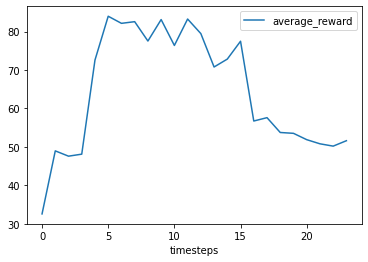

In [19]:
import matplotlib.pyplot as plt
import pandas as pd

data = pd.read_csv('average_reward.csv') 
mean_reward = data.groupby(['timesteps'], as_index=False).mean()
mean_reward.to_csv('grouped_average_reward.csv')

ax = plt.gca() 
mean_reward.plot(kind='line', x='timesteps', y='average_reward', ax=ax)
plt.show()

# Cleanup
Delete services:

In [18]:
for x in range(num_of_services):
    delete_service(x)